<a href="https://colab.research.google.com/github/sauddy/DPCNet/blob/main/DPCNet_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subhrat Tuner code with the new PMEA Function
## DPNNet-RT -- 14 June  2022 (Colab Compatible)

This notebook is created to build a ML model that can Classify the number of hidden planets and Predict the 
corresponding planet mass for each of the planet from the protoplanetary disk images directly


#####    Please note this version of the code is compatible with Google colab 
#####    and will also run on Local machine (M1 Mac)  
#####    In this notebook we will use the multi-output planet mass 

 

In [139]:
# ####mount the drive if running from Colab
# from google.colab import drive
# drive.mount('/content/drive/')

### IDEA behind this notebook : 
#### Author : Sayantan 
#### Created : 3 Feb 2022
#### This notebook is adopted from the DPNNet-2.0

#### Updated: 24 Feb 2022 to include multi-outputs

This notebook is developed to train the Model with RT images:
We want to perform the following set of tasks

 P.S.This is a modular notebook that does the following:
 1. Import all the customized Modules from Modules_DPNNet 
 2. For data processing we use RTdata_processing.py script 
 3. A functional module to call the different networks independently. (deep_models.py, other_cnn.py)




In [140]:
# import the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import cv2
import os
import csv

## Modules to check the performance of the code
from time import process_time 
# !pip install memory_profiler ## When running from Google Colab
# import memory_profiler as mem_profile
# print('Memory (Before): {}Mb'.format(mem_profile.memory_usage()))


## Importing the necessary TesnorFLow modules modules
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')

from tensorflow import keras
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score ## form calcualting the r2 score
from sklearn.utils import shuffle
from tensorflow import keras as k



In [141]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  1
2.9.0


In [142]:
############ Please provide the same path to the code directory if using Colab################

Path_gdrive= '/content/drive/MyDrive/ISU_Regresion/DPNNet-RT/' ## Comment out this line if using local computer

## Importing the Modules from Modules_DPNNet
import sys
try: ## tries to find the modules in the local directory first
  current_directory = os.getcwd()
  path = current_directory + '/' # For local computer 
#   path = '' # For local computer  
  sys.path.append(path+'MODULES_DPNNeT')
  import data_processing_RT as dp
  import deep_models as dm
  import other_cnns as ocn

  ########### Folders to save the processed data, files and figures when using Local computer ##############
  output_folder_list = ['data_folder','figures','saved_model', 'one_planet_sims', 'two_planet_sims', 'three_planet_sims']
  for file in output_folder_list:
    try:
        os.makedirs(file)
    except OSError:
        print ("Creation of the directory %s failed/ not needed as it already exit" % file)
    else:
        print ("Successfully created the directory %s" % file)
  
except ModuleNotFoundError:
  
  # #For Colab use:
  # #Point to the path containing the modules in the above section
  #(data folder are a directory above the directory containing the notebook)
  try:
    path = Path_gdrive
    print(path)
    sys.path.append(path+'MODULES_DPNNeT')
    import data_processing_RT as dp
    import deep_models as dm
    import other_cnns as ocn

    ########### Folders to save the processed data, files and figures when using GDRIVE ##############
    import os
    os.chdir(path)   
    print("Creating the folders")
    !mkdir -p data_folder
    !mkdir -p figures ## to save the figures
    !mkdir -p figures_paper
    !mkdir -p saved_model
    !mkdir -p one_planet_sims
    !mkdir -p two_planet_sims
    !mkdir -p three_planet_sims
  except ModuleNotFoundError:
    print("The path to the modules is incorrect-- Provide current path")

print("[INFO] Modules imported")

Creation of the directory data_folder failed/ not needed as it already exit
Creation of the directory figures failed/ not needed as it already exit
Creation of the directory saved_model failed/ not needed as it already exit
Creation of the directory one_planet_sims failed/ not needed as it already exit
Creation of the directory two_planet_sims failed/ not needed as it already exit
Creation of the directory three_planet_sims failed/ not needed as it already exit
[INFO] Modules imported


## Creating a csv with simulations params and path to each RT images

In [143]:
## Taking a look at the paramter file 
parameter_df = dp.load_parameter_csv(path)
parameter_df

,Planet_Mass1,Planet_Mass2,Planet_Mass3,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Flaring_Index,Rp1,Rp2,Rp3
0,0.002110,0.00237,0.001880,0.1,0.03000,0.160000,0.0475,1.0,0.0,1.050,2.16,3.03
1,0.001850,0.00195,0.002710,0.1,0.00050,0.030000,0.0389,1.0,0.0,1.160,2.00,2.99
2,0.001340,0.00296,0.002790,0.1,0.00999,0.160000,0.0518,1.0,0.0,0.874,1.83,2.98
3,0.000492,0.00129,0.002130,0.1,0.00999,0.160000,0.0668,1.0,0.0,1.110,2.05,3.13
4,0.002360,0.00162,0.000963,0.1,0.00999,0.000157,0.0754,1.0,0.0,0.954,1.82,2.96
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001120,0.00000,0.000000,0.1,0.03000,0.160000,0.0675,1.0,0.0,1.030,1.84,3.32
96,0.000322,0.00000,0.000000,0.1,0.00050,0.160000,0.0425,1.0,0.0,1.160,2.11,3.04
97,0.002500,0.00000,0.000000,0.1,0.00999,0.000157,0.0375,1.0,0.0,0.867,1.89,3.24
98,0.001310,0.00000,0.000000,0.1,0.00999,0.030000,0.0925,1.0,0.0,1.080,2.03,3.28


## Move the images from the original folder to the code directory 

Only needed initially for moving the images to the working directory--
Ones the data is moved there is no need for this code block

In [144]:
############# to move the images from the original folder to the code directory ###################
# ## Path to the RT image folder
# RT_Folder_Path = "/Users/sauddy/OneDrive - Iowa State University/images/examples/"


# list_RT_path = glob.glob(RT_Folder_Path+ 'RT_A*') ## make a list of all the RT folder where each folder is for each sim
# list_sorted_RT_path  = sorted(list_RT_path, key=lambda x: int(x.split('/')[6].split('_')[2])) ## sorting the images


# ############### Moved the images to the code directory for convenience ######
# import shutil
# try:
#     os.mkdir('image_directory')
# except OSError:
#      print ("Creation of the directory %s failed/ not needed as it already exit" % file)
# NEW_IMAGE_PATH = 'image_directory'
# os.chdir(NEW_IMAGE_PATH)
# for index in range(len(list_sorted_RT_path)):
#     try:
#         os.mkdir('RT_A_'+ str(index+1))
#     except OSError:
# #          print ("Creation of the directory %s failed/ not needed as it already exit" % file)
#          pass
    
#     destination_path = 'RT_A_'+ str(index+1)
#     for img in glob.glob(list_sorted_RT_path[index] + "/images/snu/"+ "image_"+"*.png"):
#         shutil.copy(img, destination_path)

# os.chdir('../')

############## END ##############################

#### Address to the data folder 

Genrating the .csv file with the image address to load them later

In [145]:
############# Address to the data folder ###################

# ## updating the image paths once the transfer is done
list_RT_path = glob.glob(path+ 'image_directory/'+ 'RT_A*') ## make a list of all the RT folder where each folder is for each sim

## When using the local M1
# list_sorted_RT_path  = sorted(list_RT_path, key=lambda x: int(x.split('/')[1].split('_')[2])) ## sorting the images


# ## For google colab this needs to be updated
import re
list_sorted_RT_path  = sorted(list_RT_path, key=lambda f: [int(n) for n in re.findall(r"\d+", f)][-1]) ## sorting the images

# print(list_sorted_RT_path[0])


# The idea is to generate a dataframe with the parameters and the path to the images
data_complete = dp.create_complete_data_csv(list_sorted_RT_path,path)
# data_complete
## Removing the nan if any
data_complete.isna().sum()  # summing the number of na
data_complete= data_complete.dropna()

# data_complete['Planet_Count'] = (data_complete.loc[:, ['Planet_Mass1', 'Planet_Mass2', 'Planet_Mass3']] != 0).sum(axis=1)
data_complete = shuffle(data_complete,random_state=42)
data_complete= data_complete[:100] ## Select less numbers of images for quick results
data_complete

[INFO]: Importing path for all the RT images
[INFO]: Contatinating the paths of all the RT images is now complete


,Planet_Mass1,Planet_Mass2,Planet_Mass3,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Flaring_Index,Rp1,Rp2,Rp3,image_path
11519,147.000000,60.000000,0.000000,0.1,0.00999,0.030000,0.0595,1.0,0.0,1.180,1.90,3.32,/scratch/sauddy3/DPNNet-RT/DPNNet-RT/image_dir...
6485,27.833333,0.000000,863.333333,0.1,0.00050,0.030000,0.0925,1.0,0.0,0.984,1.97,3.39,/scratch/sauddy3/DPNNet-RT/DPNNet-RT/image_dir...
13187,503.333333,0.000000,0.000000,0.1,0.03000,0.030000,0.0575,1.0,0.0,1.130,1.81,2.92,/scratch/sauddy3/DPNNet-RT/DPNNet-RT/image_dir...
862,277.333333,261.000000,403.333333,0.1,0.00999,0.030000,0.0646,1.0,0.0,1.150,2.02,3.37,/scratch/sauddy3/DPNNet-RT/DPNNet-RT/image_dir...
5980,543.333333,0.000000,400.000000,0.1,0.00050,0.000157,0.0535,1.0,0.0,1.180,1.95,2.96,/scratch/sauddy3/DPNNet-RT/DPNNet-RT/image_dir...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11772,663.333333,333.333333,1000.000000,0.1,0.03000,0.160000,0.0865,1.0,0.0,1.140,2.10,3.18,/scratch/sauddy3/DPNNet-RT/DPNNet-RT/image_dir...
6136,783.333333,0.000000,321.000000,0.1,0.03000,0.030000,0.0805,1.0,0.0,0.968,2.03,3.08,/scratch/sauddy3/DPNNet-RT/DPNNet-RT/image_dir...
14649,833.333333,0.000000,0.000000,0.1,0.00999,0.000157,0.0375,1.0,0.0,0.867,1.89,3.24,/scratch/sauddy3/DPNNet-RT/DPNNet-RT/image_dir...
2688,79.000000,177.333333,265.666667,0.1,0.00999,0.160000,0.0539,1.0,0.0,1.030,2.09,3.22,/scratch/sauddy3/DPNNet-RT/DPNNet-RT/image_dir...


## Preparing data 

In [146]:
## partition the data csv file into training and testing splits using 85% of
## the data for training and the remaining 15% for testing
split = train_test_split(data_complete, test_size=0.15, random_state=42)
(train, test) = split

## Save the train and the test data for future use as well.
test.to_csv(path+'data_folder/test_dataset.csv')
train.to_csv(path+'data_folder/train_dataset.csv')


## Generate the Normalized data
normed_train_data, normed_test_data, train_labels, test_labels = dp.process_the_disk_attributes(train, test, path,multi_label=True)


#### Desired Image resoltuion #####
X_res = Y_res = 64

## Generate the training and the test images 

trainImagesX = dp.load_disk_images(train, X_res, Y_res, Type = "Train")
testImagesX = dp.load_disk_images(test, X_res, Y_res, Type = "Test")

Validation_split = 0.15 # 15 percent of the training data is used for validation
# print('Memory (After Loading): {}Mb'.format(mem_profile.memory_usage()))
print('There are {} Train, {} Validation and {} Test images'.format(int((1-Validation_split)*len(normed_train_data)),int(Validation_split*len(normed_train_data)),len(normed_test_data)))## check the numbers in each chategory



[INFO] preparing the normalized data training/testing split...
Droping the irrelevant columns 
INFO: considering multiple planets as output
[INFO] Done...
[INFO] Loading images from Train data..
Train Images are loaded
[INFO] Loading images from Test data..
Test Images are loaded
There are 72 Train, 12 Validation and 15 Test images


In [147]:
# train_labels
# test
# normed_test_data

### Checking one image for verification

In [148]:
# test = list_sorted_RT_path[0] +  "/images/snu/"+ "image_"+"7.png"
# print(test)
# # dimensions for cropping the image
# top = 54
# left = 102
# bottom = 430
# right = 480
# X_res = Y_res = 512
# image = cv2.imread(test)  
# crop_image = image[top:bottom, left:right]
# crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
# crop_image = k.preprocessing.image.img_to_array(crop_image) ## changing to numpy array
# datagen = k.preprocessing.image.ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,rescale= 1.0/255.0)
# crop_image = datagen.standardize(np.copy(crop_image))
# plt.imshow(crop_image)
# plt.show()
# cv2.imshow('sample image',image)

,Planet_Mass1,Planet_Mass2,Planet_Mass3
5980,543.333333,0.000000,400.000000
3338,390.000000,513.333333,653.333333
5033,476.666667,623.333333,238.000000
12827,636.666667,0.000000,0.000000
2858,560.000000,483.333333,350.000000
...,...,...,...
3034,503.333333,930.000000,516.666667
7427,226.333333,333.333333,127.000000
6715,147.000000,333.333333,903.333333
13959,703.333333,0.000000,0.000000


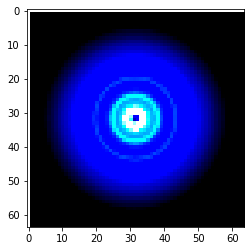

In [149]:
np.shape(trainImagesX[1])
plt.imshow(trainImagesX[5])
train_labels

### Preparing the dataset for the classification problem--- 

##### We are using the one-hot encoding to label the one, two, and three planet system

### Preparing the data for Classification

In [150]:
X_train=trainImagesX
X_test=testImagesX

## For classification we included binary 1 or 0 dependent on if the planet is present or not respectively
## Since Planet 1 is always there we do it for planet 2 and 3 only

# train['PM1'] = np.where(train['Planet_Mass1']!= 0, 1,0)
train['PM2'] = np.where(train['Planet_Mass2']!= 0, 1,0)
train['PM3'] = np.where(train['Planet_Mass3']!= 0, 1,0)

test['PM2'] = np.where(test['Planet_Mass2']!= 0, 1, 0)
test['PM3'] = np.where(test['Planet_Mass3']!= 0, 1, 0)

Y_train=train[["PM2","PM3"]]
Y_test=test[["PM2","PM3"]]

In [151]:
Y_test
Y_train

,PM2,PM3
5980,0,1
3338,1,1
5033,1,1
12827,0,0
2858,1,1
...,...,...
3034,1,1
7427,1,1
6715,1,1
13959,0,0


### Different CNN models

Will be later moved to the module folder

In [152]:

# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


# modules added for the RESNET50
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D, Add


######## Alexnet


def alexnet(width, height, depth, classes=None,regress=False,multi_label=False,classification=False,option=None):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)


# define the model input
    X_input = Input(shape=inputShape)
    # X_input = Input(shape=inputShape)

# 1st Convolutional Layer
    x = Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding="same")(X_input)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)

# 2nd Convolutional Layer
    x = Conv2D(256, kernel_size=(11, 11), strides=(1, 1), activation='relu', padding="same")(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)

# 3rd Convolutional Layer
    x = Conv2D(384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same")(x)

# 4th Convolutional Layer
    x = Conv2D(384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same")(x)

# 5th Convolutional Layer
    x = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same")(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)


# Passing it to a Fully Connected layer
    x = Flatten()(x)
# 1st Fully Connected Layer
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization(axis=1)(x)
# Add Dropout to prevent overfitting
    x = Dropout(0.4)(x)

# 2nd Fully Connected Layer
    x = Dense(4096, activation='relu')(x)
# Add Dropout
    x = Dropout(0.4)(x)

# 3rd Fully Connected Layer
    x = Dense(1000, activation='relu')(x)
    x = BatchNormalization(axis=1)(x)
# Add Dropout
    x = Dropout(0.4)(x)

# # Output Layer
#     x = Dense(4)(x)
#     # x=Activation("relu")(x)

    XX = Flatten()(x)
   
    if classification==True:
      # print("A new fully Connexted layer is added")
       ## Adding a Fully connected layer for classification
      Xclas = XX
      
      Xclas = Dense(100, kernel_initializer='he_uniform', activation='relu')(Xclas)
      # Xclas = BatchNormalization(axis=1)(Xclas) 
      print("INFO:CNN is used for classification")
      if option ==1:
        print("Additional INFO:Using Softmax for classification")
        Xclas = Dense(units=classes, activation='softmax')(Xclas) 
      else:  
        print("Additional INFO: Using Sigmoid activation for classification")
        Xclas = Dense(units=classes, name='cla',activation='sigmoid')(Xclas)
      out_clas = Xclas 

    if regress == True:
      print("INFO:CNN is used for regression")
      if multi_label==False:           
        Xreg = Dense(1, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
      if multi_label==True: 
        ## 28 Feb 2022 added the multi-label output 
        print("INFO: Note Multiple Labels are optimised during regression")
        Xreg = Dense(3, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
      out_reg = Xreg
    # else:
    #     print("Multi-input is initiated")
    #     X = Dense(4)(X)
    #     X = Activation("relu")(X)
    

    # Create model

    optimizer = tf.keras.optimizers.Adam(init_lr, decay=init_lr/2000)

    if classification == True and regress == True:
      print("INFO: Performing both regression and classification -- Model Training")
      modelalexnet = Model(inputs = X_input,outputs=[out_reg, out_clas])
      modelalexnet.compile(loss=['mean_squared_error','binary_crossentropy'],optimizer=optimizer,metrics=['mean_squared_error', 'accuracy'])
    elif regress == False:
      X = out_clas
      print("INFO: Classification Model is being trained")
      modelalexnet = Model(inputs = X_input, outputs = X)
      modelalexnet.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    elif classification is False:
      X = out_reg
      print("INFO: Regression Model is being trained")
      modelalexnet = Model(inputs = X_input, outputs = X)
      modelalexnet.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])

    return modelalexnet




############ vgg 16


def cnn_vgg(width, height, depth, classes=None,regress=False,multi_label=False,classification=False,option=None):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)


    # define the model input
    X_input = Input(shape=inputShape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(X_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = Flatten(name='flatten')(x)
    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    
    
    XX = Flatten()(x)
   
    if classification==True:
      # print("A new fully Connexted layer is added")
       ## Adding a Fully connected layer for classification
      Xclas = XX
      
      Xclas = Dense(100, kernel_initializer='he_uniform', activation='relu')(Xclas)
      # Xclas = BatchNormalization(axis=1)(Xclas) 
      print("INFO:CNN is used for classification")
      if option ==1:
        print("Additional INFO:Using Softmax for classification")
        Xclas = Dense(units=classes, activation='softmax')(Xclas) 
      else:  
        print("Additional INFO: Using Sigmoid activation for classification")
        Xclas = Dense(units=classes, name='cla',activation='sigmoid')(Xclas)
      out_clas = Xclas 

    if regress == True:
      print("INFO:CNN is used for regression")
      if multi_label==False:           
        Xreg = Dense(1, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
      if multi_label==True: 
        ## 28 Feb 2022 added the multi-label output 
        print("INFO: Note Multiple Labels are optimised during regression")
        Xreg = Dense(3, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
      out_reg = Xreg
    # else:
    #     print("Multi-input is initiated")
    #     X = Dense(4)(X)
    #     X = Activation("relu")(X)
    

    # Create model

    optimizer = tf.keras.optimizers.Adam(init_lr, decay=init_lr/2000)

    if classification == True and regress == True:
      print("INFO: Performing both regression and classification -- Model Training")
      modelvgg = Model(inputs = X_input,outputs=[out_reg, out_clas])
      modelvgg.compile(loss=['mean_squared_error','binary_crossentropy'],optimizer=optimizer,metrics=['mean_squared_error', 'accuracy'])
    elif regress == False:
      X = out_clas
      print("INFO: Classification Model is being trained")
      modelvgg = Model(inputs = X_input, outputs = X)
      modelvgg.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    elif classification is False:
      X = out_reg
      print("INFO: Regression Model is being trained")
      modelvgg = Model(inputs = X_input, outputs = X)
      modelvgg.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])

    return modelvgg

####### RESNET50

#identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X


def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X
def Resnet50(width, height, depth,classes=None,regress=False,multi_label=False,classification=False,option=None):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    inputShape = (height, width, depth)
    

    # define the model input
    X_input = Input(shape=inputShape)



    # Define the input as a tensor with shape input_shape
    #X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [256,256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)
    
    ## made the changes on 15 Feb 2021
    # output layer
    XX = Flatten()(X)
    # XX = layers.GlobalAveragePooling2D(name="avg_pool")(X)
    XX = Dense(100, kernel_initializer='he_uniform', activation='relu')(XX) 
   
    if classification==True:
      # print("A new fully Connexted layer is added")
       ## Adding a Fully connected layer for classification
      Xclas = XX
      Xclas = BatchNormalization(axis=1)(Xclas)   
      top_dropout_rate = 0.30
      # Xclas = layers.Dropout(top_dropout_rate, name="top_dropout1")(Xclas)  
      Xclas = Dense(50, kernel_initializer='he_uniform', activation='relu')(Xclas)
      Xclas = BatchNormalization(axis=1)(Xclas)
      # top_dropout_rate = 0.20
      # Xclas = layers.Dropout(top_dropout_rate, name="top_dropout2")(Xclas)
      Xclas = Dense(20, kernel_initializer='he_uniform', activation='relu')(Xclas)
      Xclas = BatchNormalization(axis=1)(Xclas)
        
      print("INFO:CNN is used for classification")
      if option ==1:
        print("Additional INFO:Using Softmax for classification")
        Xclas = Dense(units=classes, activation='softmax', name='cla')(Xclas) 
      else:  
        print("Additional INFO: Using Sigmoid activation for classification")
        Xclas = Dense(units=classes, name='cla',activation='sigmoid')(Xclas)
      out_clas = Xclas 

    if regress == True:
      print("INFO:CNN is used for regression")
      if multi_label==False:           
        Xreg = Dense(1, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
      if multi_label==True: 
        ## 28 Feb 2022 added the multi-label output 
        print("INFO: Note Multiple Labels are optimised during regression")
        Xreg = Dense(3, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
      out_reg = Xreg
    # else:
    #     print("Multi-input is initiated")
    #     X = Dense(4)(X)
    #     X = Activation("relu")(X)
    
   

    #### Create model ###

    optimizer = tf.keras.optimizers.Adam(init_lr, decay=init_lr/2000)

    if classification == True and regress == True:
      print("INFO: Performing both regression and classification -- Model Training")
      modelresnet = Model(inputs = X_input,outputs=[out_reg, out_clas])
      modelresnet.compile(loss=['mean_squared_error','binary_crossentropy'],optimizer=optimizer,metrics=['mean_squared_error', 'accuracy'])
    elif regress == False:
      X = out_clas
      print("INFO: Classification Model is being trained")
      modelresnet = Model(inputs = X_input, outputs = X)
      modelresnet.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    elif classification is False:
      X = out_reg
      print("INFO: Regression Model is being trained")
      modelresnet = Model(inputs = X_input, outputs = X)
      modelresnet.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])

    return modelresnet


### Transfer Learning Codes

Will be later moved to the Module Folder

https://towardsdatascience.com/hyperparameter-tuning-with-keras-tuner-283474fbfbe

In [153]:
#!pip install keras-tuner
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1 
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5 
from tensorflow.keras.applications import EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import ResNet50,ResNet50V2
import keras_tuner as kt
from keras_tuner import HyperModel

#width = X_res
#height = Y_res
#depth = 3
#transfer_model = ResNet50


class TRANSFERLEARNINGHYPERMODEL(HyperModel):
    
    def __init__(self,width,height,depth,classes=None,regress=False,multi_label=False,classification=False,option=None,transfer_model= None):
          self.width = width
          self.height = height
          self.depth = depth
          self.classes = classes
          self.regress = regress
          self.multi_label = multi_label
          self.classification = classification
          self.option = option
          self.transfer_model = transfer_model
          print(self.transfer_model)
    
    def build(self, hp):

          '''
          This function introduces the use of Transfer learning to train the DPNNet Model
          Here we use the pretrained weights from the Imagenet data set
          
          Please note this here update the final layers to perform regress or classification
          or both regression and classification together
          
          Input:  1. Dimension of the image [width,height,depth]
                  2. Number of classsification classes if used for calssification
                  3. Regress on or off
                  4. Multilabel -- True for multi-label regression Default == False
                  5. Classification -- True or False 
                  6. Option is the argument to use either softmax (default) or sigmoid for classification
                  7. Select the transfer Learning Model from Either 3 RESNET50 or Efficientnet0-7 models
                  
                  
          Output : Model Build 
          
          '''
          
          ## Input layers
          X_input = layers.Input(shape=(self.height, self.width, self.depth))
          x = X_input
          
          if self.transfer_model == None:
              self.transfer_model = EfficientNetB6
              print("Please Select the Network that will be used-- By Default {} will be used".format(str.lower(self.transfer_model.__name__)))
          
          #### Selecting the model along with the pretrained weights
          mod_name = self.transfer_model.__name__
          print("INFO: Keras Model used is {}".format(mod_name))
          print("Loading weights for {} since this notebook is not connected to internet".format(str.lower(mod_name)))
          
          print("Loading weights for {} since this notebook is not connected to internet".format(str.lower(mod_name)))
          
            
          try:
            model = transfer_model(include_top=False,input_tensor=x, weights='preloaded_weights/'+str.lower(mod_name)+'_notop.h5')
          except ValueError:
            model = transfer_model(include_top=False,input_tensor=x, weights='preloaded_weights/'+str.lower(mod_name)+'_weights_tf_dim_ordering_tf_kernels_notop.h5')  
          
          # try:
          #     model = self.transfer_model(include_top=False,input_tensor=x, weights='imagenet')
          # except ValueError:
          #     model = self.transfer_model(include_top=False,input_tensor=x, weights='imagenet')
        
          
          # Freeze the pretrained weights
          model.trainable = True

          # Rebuild top

          x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
          x = layers.BatchNormalization()(x)

          top_dropout_rate = 0.2
          x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

          XX = Flatten()(x)
          XX = Dense(100, kernel_initializer='he_uniform', activation='relu')(XX) 
          # outputs = layers.Dense(classes, activation="softmax", name="pred")(x)


          if self.classification==True:
            # print("A new fully Connexted layer is added")
            ## Adding a Fully connected layer for classification
            Xclas = XX
            # Xclas = BatchNormalization(axis=1)(Xclas)   
            # top_dropout_rate = 0.30
            # # Xclas = layers.Dropout(top_dropout_rate, name="top_dropout1")(Xclas)  
            # Xclas = Dense(50, kernel_initializer='he_uniform', activation='relu')(Xclas)
            # Xclas = BatchNormalization(axis=1)(Xclas)
            # # top_dropout_rate = 0.20
            # # Xclas = layers.Dropout(top_dropout_rate, name="top_dropout2")(Xclas)

            

            for i in range(hp.Int('num_of_layers',min_value=1,max_value=8,step=1)):         
              #providing range for number of neurons in hidden layers
              Xclas = Dense(units=hp.Int('num_of_neurons_'+ str(i),min_value=10,max_value=40,step=5), kernel_initializer='he_uniform', activation='relu')(Xclas)
          

            Xclas = BatchNormalization(axis=1)(Xclas)

            Xclas = Dropout(hp.Float('dropout_rate',min_value=0, max_value=0.4, step=0.05), name="classification_dropout")(Xclas)

            Xclas = Dense(units=hp.Int('num_of_neurons',min_value=10,max_value=40,step=5), activation='relu')(Xclas)

            if hp.Choice('activation', ['softmax', 'sigmoid']) == 'softmax':
              Xclas = Dense(units=self.classes, activation='softmax', name='clas')(Xclas)
            else:
              Xclas = Dense(units=self.classes, activation='sigmoid', name='clas')(Xclas)

            out_clas = Xclas 


          if self.regress == True:
            print("INFO:CNN is used for regression")
            if self.multi_label==False:           
              Xreg = Dense(1, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
            if self.multi_label==True: 
              ## 28 Feb 2022 added the multi-label output 
              print("INFO: Note Multiple Labels are optimised during regression")
              Xreg = Dense(3, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
            out_reg = Xreg
          # else:
          #     print("Multi-input is initiated")
          #     X = Dense(4)(X)
          #     X = Activation("relu")(X)
          

          ### Create model
          
          optimizer = tf.keras.optimizers.Adam(init_lr, decay=init_lr/2000)

          from keras import backend as K

          def pmae(y_true, y_pred):
              if not tf.is_tensor(y_pred):
                  y_pred = K.constant(y_pred)
              y_true = K.cast(y_true, y_pred.dtype)
              diff = K.mean(K.abs((y_pred - y_true)) / K.mean(K.clip(K.abs(y_true),
                                                                    K.epsilon(),
                                                                    None)))
              return K.mean(diff)          

          if self.classification == True and self.regress == True:
            print("INFO: Performing both regression and classification -- Model Training")
            modelNEWCNN = Model(inputs = X_input,outputs=[out_reg, out_clas])
            modelNEWCNN.compile(loss=[pmae,'binary_crossentropy'],optimizer=optimizer,metrics=['mean_squared_error', 'accuracy'])
          elif self.regress == False:
            X = out_clas
            print("INFO: Classification Model is being trained")
            modelNEWCNN = Model(inputs = X_input, outputs = X)
            modelNEWCNN.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
          elif self.classification is False:
            X = out_reg
            print("INFO: Regression Model is being trained")
            modelNEWCNN = Model(inputs = X_input, outputs = X)
            modelNEWCNN.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])

          return modelNEWCNN

## Training the CNN 

In [154]:
## Hyper-Parameter to define
batch_size = 200 ## 20 was for regression ## the best was for 200 last run
valid_batch_size = 200
epochs=200 ## best was 100
init_lr = 1e-5 # 1e-5 (works for regression)

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=2e-6, patience=30, verbose=1, mode='min',restore_best_weights=True)



In [155]:
#!pip install keras-tuner
#from keras_tuner import RandomSearch

#tuner_c=RandomSearch(TRANSFERLEARNING,
#    objective='val_accuracy',
#    max_trials=5,
#    executions_per_trial=3,
#    directory='tuner_c',
#    project_name='ppd_c')

In [156]:
#tuner_c.search_space_summary()

In [157]:
#tuner_c.search(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test), callbacks=[early_stop])

In [158]:
#tuner_c.results_summary()

In [159]:
#model_c_final=tuner_c.get_best_models(num_models=1)[0]

In [160]:
## Select the Network type

# NETWORK = "Vanilla" ## Cannot be uses at the moment
# NETWORK = "ALEXNET"
# NETWORK = "VGG"
# NETWORK = "RESNET50"
NETWORK = "TRANSFERLEARNINGHYPERMODEL"
transfer_model = ResNet50

## Select the kind of Traning ## Both can be selected as well
REG = True  ## When choosing regression
CLA = True  ## When Choosing Clasiffication

print('INFO: Currently training using the {} NETWORK with regression = {} and classification = {}'.format(NETWORK,REG,CLA))
if NETWORK == "Vanilla":
    CNN = dm.build_cnn(X_res, Y_res, 3, regress=True)
elif NETWORK == "ALEXNET":
    CNN = alexnet(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "VGG":
    CNN = cnn_vgg(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "RESNET50":
    CNN = Resnet50(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
    # CNN = ocn.ResNet50(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "TRANSFERLEARNINGHYPERMODEL":
    hypermodel = TRANSFERLEARNINGHYPERMODEL(width=X_res,height=Y_res,depth=3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None,transfer_model=transfer_model)
    tuner_bo = kt.BayesianOptimization(
            hypermodel,
            objective=kt.Objective('loss', direction="min"),
            max_trials=10,
            seed=42,
            beta = 4.0,
            executions_per_trial=3
        )
    tuner_bo.search(trainImagesX, [train_labels,Y_train], epochs=10, validation_split=0.2, verbose=1)
    CNN = tuner_bo.get_best_models(num_models=1)[0]

    #CNN = TRANSFERLEARNING(width=X_res,height=Y_res,depth=3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None,transfer_model=transfer_model)


if REG == True and CLA ==False:

    # When used for regression
    CNN_history = CNN.fit(x=trainImagesX, y=train_labels,
                      validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])

if REG == False and CLA ==True:
    #When used for classification
    CNN_history = CNN.fit(x=X_train, y=Y_train,
                      validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])


if REG == True and CLA ==True:
    # When used for classification and regression
    CNN_history = CNN.fit(x=X_train, y=[train_labels,Y_train],
                      validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])

# print('Memory (After Training): {}Mb'.format(mem_profile.memory_usage()))

INFO: Currently training using the TRANSFERLEARNINGHYPERMODEL NETWORK with regression = True and classification = True
<function ResNet50 at 0x2b8a01dd5e50>
INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO: Keras Model used is ResNet50
Loading weights for resnet50 since this notebook is not connected to internet
Loading weights for resnet50 since this notebook is not connected to internet
INFO:CNN is used for regression
INFO: Note Multiple Labels are optimised during regression
INFO: Performing both regression and classification -- Model Training
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


INFO: Keras Model used is ResNet50
Loading weights for resnet50 since this notebook is not connected to internet
Loading weights for resnet50 since this notebook is not connected to internet
INFO:CNN is used for regression
INFO: Note Multiple Labels are optimised during regression
INFO: Performing both regression and classification -- Model Training
Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 1.5587 - reg_loss: 0.9988 - clas_loss: 0.5599 - reg_mean_squared_error: 277019.8438 - reg_accuracy: 0.3472 - clas_mean_squared_error: 0.2975 - clas_accuracy: 0.3194 - val_loss: 1.7145 - val_reg_loss: 0.9977 - val_clas_loss: 0.7168 - val_reg_mean_squared_error: 184502.1406 - val_reg_accuracy: 0.3846 - val_clas_mean_squared_error: 0.2580 - val_clas_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 184ms/step - loss: 1.5614 - reg_loss: 0.9988 - clas_loss: 0.5625 - reg_mean_squared_error: 277070.2812 - reg_accuracy: 0.3889 - clas_mean_squared_error: 0

In [161]:
# The plots for the Validation and the Testing loss
# dp.plot_history(CNN_history,path, Model = "CNN")
hist_df = pd.DataFrame(CNN_history.history)  ## converting to dataframe
## Saving the history
if REG == True and CLA == True:
    hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelRC'+'_history.csv')
elif REG == True and CLA == False:
    hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelR'+'_history.csv')    
elif CLA == True and REG == False:
    hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelC'+'_history.csv')

## Saving the network for future use

In [162]:
#uncomment the following lines if you want to update your model

if REG == True and CLA == True:
    CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
elif REG == True and CLA == False:
    CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')
elif CLA == True and REG == False:
    CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelC')



INFO:tensorflow:Assets written to: /scratch/sauddy3/DPNNet-RT/DPNNet-RT/saved_model/TRANSFERLEARNINGHYPERMODEL_64_modelRC/assets


INFO:tensorflow:Assets written to: /scratch/sauddy3/DPNNet-RT/DPNNet-RT/saved_model/TRANSFERLEARNINGHYPERMODEL_64_modelRC/assets


In [163]:
def pmae(y_true, y_pred):
              if not tf.is_tensor(y_pred):
                  y_pred = K.constant(y_pred)
              y_true = K.cast(y_true, y_pred.dtype)
              diff = K.mean(K.abs((y_pred - y_true)) / K.mean(K.clip(K.abs(y_true),
                                                                    K.epsilon(),
                                                                    None)))
              return K.mean(diff)          
# Loading the model
if REG == True and CLA == True:
    CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC', custom_objects={'pmae': pmae})
elif REG == True:
    CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')
elif CLA == True:
    CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')


# CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
#Check its architecture
# CNN.summary()

## Model Evaluation for DPCNet

In [164]:
# loss, mae, mse_CNN = CNN.evaluate(testImagesX, test_labels, verbose=0)
# print("Testing set Mean Square Error for {}: {:5.2f} ".format(NETWORK,mse_CNN))
# print("Testing set Root Mean Square Error for {}: {:5.2f} M_Earth".format( NETWORK,np.sqrt(mse_CNN)))
# print("Testing set Mean Abs Error for {} : {:5.2f} M_Earth ".format(NETWORK,mae))
# print("Testing set Loss for {}: {:5.2f} M_Earth".format(NETWORK,loss))

## PLotting the accuracy when used for Classification

In [165]:
# acc = CNN_history.history['accuracy']
# val_acc = CNN_history.history['val_accuracy']
# loss =CNN_history.history['loss']
# val_loss = CNN_history.history['val_loss']
# hist =pd.DataFrame(CNN_history.history)
# hist['epoch'] = hist.index = hist.index


# # epochs_range = range(21)

# plt.figure(figsize=(15, 15))
# plt.subplot(2, 2, 1)
# plt.plot(hist['epoch'], acc, label='Training Accuracy')
# plt.plot(hist['epoch'], val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 2, 2)
# plt.plot(hist['epoch'], loss, label='Training Loss')
# plt.plot(hist['epoch'], val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.savefig('figures/c.png')
# plt.show()



## Model Predictions and Results for the classification

In [166]:
# from numpy import argmax
# pred_CNN = CNN.predict(testImagesX)
# pred_CNN[1][1]
# # np.shape(pred_CNN)
# # type(pred_CNN)
# # test_index =150
# # pred_CNN[test_index]
# # argmax(pred_CNN[20])
# # pred_Hybird = hybrid_model.predict([normed_test_data,testImagesX])
# # np.shape(pred_Hybird)

In [167]:
# Y_test.iloc[test_index]
# # Y_test[22]
# argmax(Y_test[22]).astype('int')

# 4.8826393e-01*100

### Model Predictions and Results for the regression and Classification


In [168]:
test_index =3 ##210
pred_CNN = CNN.predict(testImagesX)
# np.shape(pred_CNN)
print(pred_CNN[1][test_index])
print(pred_CNN[0][test_index])

# pred_CNN[test_index]


1/1 [==============================] - 1s 988ms/step
[0.5438005  0.45619956]
[ 5.5845966  1.4350041 -0.9244619]


Planet_Mass1    107.333333
Planet_Mass2      0.000000
Planet_Mass3      0.000000
Name: 14502, dtype: float64

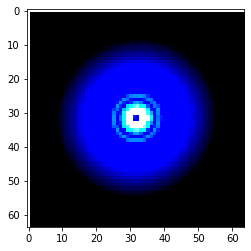

In [169]:
plt.imshow(testImagesX[test_index])
test_labels.iloc[test_index]



In [170]:
# CNN_history.history
Y_test.iloc[test_index]

PM2    0
PM3    0
Name: 14502, dtype: int64

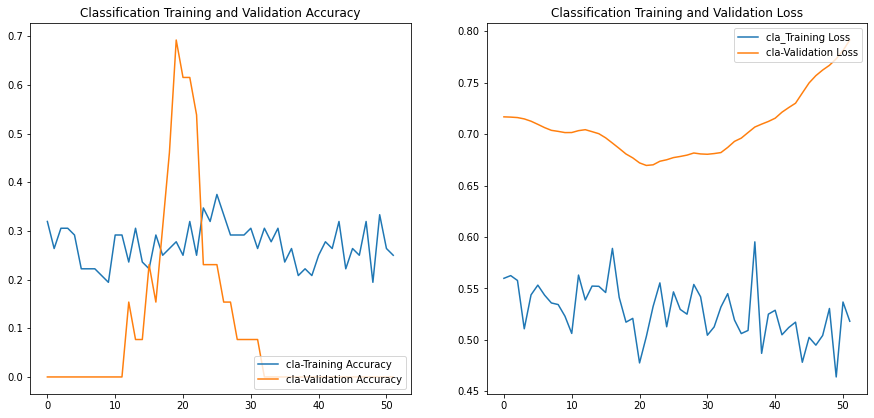

In [171]:
CNN_history.history ##val_fc_mean_squared_error val_fc_accuracy' val_dense_3_mean_squared_error val_dense_3_accuracy

###fc_mean_squared_error fc_accuracy dense_3_mean_squared_error dense_3_accuracy
hist =pd.DataFrame(CNN_history.history)
hist['epoch'] = hist.index = hist.index

if  CLA == True & REG== False:
    cla_acc = CNN_history.history['accuracy']
    val_cla_acc = CNN_history.history['val_accuracy']
    cla_loss =CNN_history.history['loss']
    val_cla_loss = CNN_history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    # plt.subplot(2, 2, 1)
    plt.plot(hist['epoch'], cla_acc, label='clas-Training Accuracy')
    plt.plot(hist['epoch'], val_cla_acc, label='clas-Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Classification Training and Validation Accuracy')
    
if REG == True & CLA == False:
    ## For Regression
    reg_mse = CNN_history.history['mean_squared_error']
    val_reg_mse =CNN_history.history['val_mean_squared_error']
    reg_loss =CNN_history.history['loss']
    val_reg_loss = CNN_history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    # plt.subplot(2, 2, 1)
    plt.plot(hist['epoch'], reg_mse, label='reg-Training MSE')
    plt.plot(hist['epoch'], val_reg_mse, label='reg-Validation MSE')
    plt.legend(loc='lower right')
    plt.title('Regression Training and Validation MSE')

if REG == True and CLA == True:
    ## For classification
    cla_acc = CNN_history.history['clas_accuracy']
    val_cla_acc = CNN_history.history['val_clas_accuracy']
    cla_loss =CNN_history.history['clas_loss']
    val_cla_loss = CNN_history.history['val_clas_loss']

    ## For Regression
    reg_mse = CNN_history.history['reg_mean_squared_error']
    val_reg_mse =CNN_history.history['val_reg_mean_squared_error']
    reg_loss =CNN_history.history['reg_loss']
    val_reg_loss = CNN_history.history['val_reg_loss']
    
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(hist['epoch'], cla_acc, label='cla-Training Accuracy')
    plt.plot(hist['epoch'], val_cla_acc, label='cla-Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Classification Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(hist['epoch'], cla_loss, label='cla_Training Loss')
    plt.plot(hist['epoch'], val_cla_loss, label='cla-Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Classification Training and Validation Loss')
    plt.savefig('figures/c.png')


In [172]:
# CNN_history.history

In [173]:
# a = EfficientNetB1
# print(a.__class__.__name__)
# print(a.__class__)
# print(a.__name__)

In [174]:
# EfficientNetB1.__name__

In [175]:
# mod_name = EfficientNetB1.__name__
# print("Keras Model used is {}".format(str.lower(mod_name)))